<a href="https://colab.research.google.com/github/felluksch/bike_hires/blob/main/timeseries_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook fits a many-to-one LSTM network for multivariate time series forecasting. Based on weather data, we try to predict the daily number of bicycles hires in London.

We import the necessary packages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import optuna

np.random.seed(10)

Next, we load the data. The first data set contains the feature that we want to predict: the daily number of bike hires in London. The second data set comprises weather data (hourly temperature, pressure and relative humidity). In addition, we generate a variable that contains the day of the week.

In [2]:
url1 = "https://data.london.gov.uk/download/number-bicycle-hires/ac29363e-e0cb-47cc-a97a-e216d900a6b0/tfl-daily-cycle-hires.xlsx"
bike_hires = pd.read_excel(url1, sheet_name=1, usecols=[0,1], parse_dates=[0], index_col=0, names=["date", "num_hires"]) # we're only interested in the two first cols of the second sheet
bike_hires["weekday"] = bike_hires.index.dayofweek

url2 = "https://bulk.meteostat.net/hourly/03779.csv.gz"
weather = pd.read_csv(url2, compression='gzip', usecols=[0,1,2,4,10], parse_dates=[0], index_col=0, names=["date", "hour", "temp", "rel_hum", "pressure"])
weather = weather['2010-07-30':'2021-08-31']

The bike hires data is available for 2010 to 2021. However, we notice that our weather data set has missing data for 2010-2018. We can thus only use data for 2018 to 2021. As the weather data contains hourly records but not 24 hours are covered for all days in the data set, we choose data for 3pm as a proxy for the weather of the given day.

In [3]:
weather = weather[weather.hour == 15]
assert len(weather) == (weather.index.max() - weather.index.min()).days + 1
print("data available from", weather.index.min(), "to", weather.index.max())

bike_hires = bike_hires['2018-01-29':'2021-08-31']
assert len(bike_hires) == (weather.index.max() - weather.index.min()).days + 1

data available from 2018-01-29 00:00:00 to 2021-08-31 00:00:00


We quickly visualise the data.

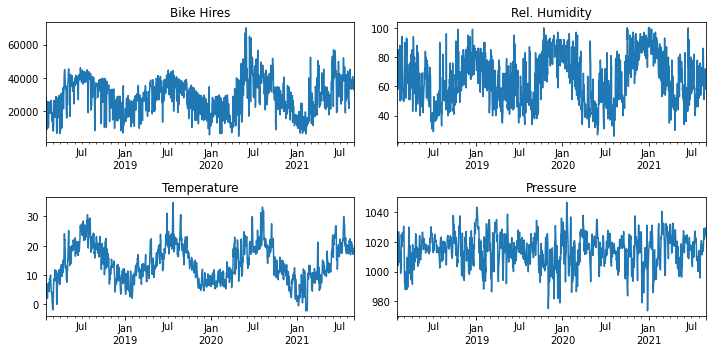

In [4]:
 fig, axes = plt.subplots(2,2, figsize=(10, 5))

 bike_hires["num_hires"].plot(ax=axes[0,0], title="Bike Hires").set_xlabel(None)
 weather["temp"].plot(ax=axes[1,0], title="Temperature").set_xlabel(None)
 weather["rel_hum"].plot(ax=axes[0,1], title="Rel. Humidity").set_xlabel(None)
 weather["pressure"].plot(ax=axes[1,1], title="Pressure").set_xlabel(None)
 plt.tight_layout()

We want to know whether some of the predictor variables are redundant. We print a correlation matrix, however, the values are not too high. We keep all features.

In [5]:
weather.corr()

,hour,temp,rel_hum,pressure
hour,NaN,NaN,NaN,NaN
temp,NaN,1.000000,-0.609505,0.154666
rel_hum,NaN,-0.609505,1.000000,-0.379380
pressure,NaN,0.154666,-0.379380,1.000000


We can get started with defining the hyperparameters of the model. We feed the model the past 90 observations (days) and want it to predict the values for 7 days in the future.

In [6]:
PAST = 90
FUTURE = 7
BATCHSIZE = 128
EPOCHS = 200
TRAIN_SIZE = 0.7

We create the target variable `num_hires_lagged` (= `num hires` in `FUTURE` timesteps). We also create a train-test split and standardise the data.

In [7]:
data = bike_hires.join(weather[["temp", "rel_hum", "pressure"]], on="date") # join dfs
assert len(data) == len(bike_hires) == len(weather)

data["num_hires_lagged"] = data["num_hires"].shift(-FUTURE) # create target
data = data[data["num_hires_lagged"].notna()] # drop rows for which we cannot create the target

split = round(TRAIN_SIZE * len(data))

scaler = StandardScaler() 
train_data = scaler.fit_transform(data.values[:split, :])
test_data = scaler.transform(data.values[split:, :])

assert len(train_data) + len(test_data) == len(data)

As we're trying to build a many-to-one LSTM, we need the input data in the following shape, so that we can use multiple sequences (all predictors) to predict a future value: 

X: `(num_obs, sequence_length, num_features)`.

y: `(num_obs,)`.

For every item in the vector y, X holds a matrix of 5 vectors: the past 90 observations for `num_hires`, `weekday`, `temp`, `rel_hum`, and `pressure`.

In [8]:
def create_many_to_one_data(matrix, PAST):
  X = np.empty((matrix.shape[0], PAST, matrix.shape[1]))
  X[:,:,:] = np.nan

  for ri in range(matrix.shape[0]): # for each time record
    for ci in range(matrix.shape[1]): # for each feature per row 
      if ri-PAST >= 0:
        X[ri,:,ci] = matrix[ri-PAST:ri,ci]

  return X[PAST:] # first rows are nans

y_col = data.shape[1] - 1
data_full = np.concatenate([train_data, test_data])
X = create_many_to_one_data(data_full[:, :y_col], PAST)
X_train = X[:split-PAST, :, :]
X_test = X[split-PAST:, :, :]
y_train = train_data[PAST:, y_col] # first obs are nans
y_test = test_data[:, y_col]

assert len(X_train) == len(y_train) == len(train_data) - PAST
assert len(X_test) == len(y_test) == len(test_data)
assert len(X_train) + len(X_test) == len(data) - PAST
assert X_train[0, 0, 3] == train_data[0, 3]

Now we can specify the model architecture and search the parameter space for optimal hyperparameters with the optuna package. We optimise the learning rate of the optimiser, the number of layers and the number of hidden states.

In [9]:
def define_model(trial):
  model = keras.Sequential()
  num_hidden_start = trial.suggest_int("n_units_start", 4, 128, log=True)
  model.add(keras.layers.LSTM(num_hidden_start, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

  n_layers = trial.suggest_int("n_layers", 1, 5)

  if n_layers > 2:
    for i in range(n_layers - 2):
      num_hidden = trial.suggest_int("n_units_l{}".format(i), 4, 128, log=True)
      model.add(keras.layers.LSTM(num_hidden, return_sequences=True))

  if n_layers >= 2:
    num_hidden_end = trial.suggest_int("n_units_end", 4, 128, log=True)
    model.add(keras.layers.LSTM(num_hidden_end))
  
  model.add(keras.layers.Dense(1))
  
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
  model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=lr), metrics=keras.metrics.RootMeanSquaredError())
  return model

path_checkpoint = "model_checkpoint.h5"
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

def objective(trial):
  keras.backend.clear_session()

  model = define_model(trial)

  model.fit(
        X_train,
        y_train,
        batch_size=BATCHSIZE,
        callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5), 
                   modelckpt_callback, 
                   optuna.integration.TFKerasPruningCallback(trial, "val_loss")
                   ],
        epochs=EPOCHS,
        validation_data=(X_test, y_test),
        verbose=1,
  )

  model.save('content/models/trial_{}'.format(trial.number)) # save model

  # Evaluate the model accuracy on the validation set
  score = model.evaluate(X_test, y_test, verbose=0)
  return score[1]

sampler = optuna.samplers.TPESampler(seed=10) 

study = optuna.create_study(sampler=sampler, direction="minimize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=100, timeout=5000)
pruned_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

[I 2021-10-07 10:39:52,560] A new study created in memory with name: no-name-8062e2c5-ef16-4cd8-9b0b-d55dbed25544


Epoch 1/200
7/7 [==============================] - 3s 211ms/step - loss: 0.9227 - root_mean_squared_error: 0.9606 - val_loss: 0.8529 - val_root_mean_squared_error: 0.9235

Epoch 00001: val_loss improved from inf to 0.85294, saving model to model_checkpoint.h5
Epoch 2/200
7/7 [==============================] - 1s 92ms/step - loss: 0.8098 - root_mean_squared_error: 0.8999 - val_loss: 0.8076 - val_root_mean_squared_error: 0.8986

Epoch 00002: val_loss improved from 0.85294 to 0.80756, saving model to model_checkpoint.h5
Epoch 3/200
7/7 [==============================] - 1s 90ms/step - loss: 0.7765 - root_mean_squared_error: 0.8812 - val_loss: 0.7814 - val_root_mean_squared_error: 0.8840

Epoch 00003: val_loss improved from 0.80756 to 0.78140, saving model to model_checkpoint.h5
Epoch 4/200
7/7 [==============================] - 1s 91ms/step - loss: 0.7540 - root_mean_squared_error: 0.8683 - val_loss: 0.7522 - val_root_mean_squared_error: 0.8673

Epoch 00004: val_loss improved from 0.78140

INFO:tensorflow:Assets written to: content/models/trial_0/assets


INFO:tensorflow:Assets written to: content/models/trial_0/assets
[I 2021-10-07 10:40:09,603] Trial 0 finished with value: 0.9452953338623047 and parameters: {'n_units_start': 56, 'n_layers': 1, 'lr': 0.0018505314477536697}. Best is trial 0 with value: 0.9452953338623047.


Epoch 1/200
7/7 [==============================] - 7s 339ms/step - loss: 0.7395 - root_mean_squared_error: 0.8599 - val_loss: 0.7578 - val_root_mean_squared_error: 0.8705

Epoch 00001: val_loss did not improve from 0.75222
Epoch 2/200
7/7 [==============================] - 1s 171ms/step - loss: 0.6044 - root_mean_squared_error: 0.7774 - val_loss: 0.7230 - val_root_mean_squared_error: 0.8503

Epoch 00002: val_loss improved from 0.75222 to 0.72303, saving model to model_checkpoint.h5
Epoch 3/200
7/7 [==============================] - 1s 166ms/step - loss: 0.5864 - root_mean_squared_error: 0.7658 - val_loss: 0.7111 - val_root_mean_squared_error: 0.8433

Epoch 00003: val_loss improved from 0.72303 to 0.71111, saving model to model_checkpoint.h5
Epoch 4/200
7/7 [==============================] - 1s 168ms/step - loss: 0.5675 - root_mean_squared_error: 0.7534 - val_loss: 0.7140 - val_root_mean_squared_error: 0.8450

Epoch 00004: val_loss did not improve from 0.71111
Epoch 5/200
7/7 [=========

INFO:tensorflow:Assets written to: content/models/trial_1/assets


INFO:tensorflow:Assets written to: content/models/trial_1/assets
[I 2021-10-07 10:40:48,535] Trial 1 finished with value: 0.8505921959877014 and parameters: {'n_units_start': 52, 'n_layers': 3, 'n_units_l0': 8, 'n_units_end': 7, 'lr': 0.003319414023327547}. Best is trial 1 with value: 0.8505921959877014.


Epoch 1/200
7/7 [==============================] - 2s 115ms/step - loss: 1.3593 - root_mean_squared_error: 1.1659 - val_loss: 1.4725 - val_root_mean_squared_error: 1.2135

Epoch 00001: val_loss did not improve from 0.67200
Epoch 2/200
7/7 [==============================] - 0s 46ms/step - loss: 1.2114 - root_mean_squared_error: 1.1006 - val_loss: 1.3329 - val_root_mean_squared_error: 1.1545

Epoch 00002: val_loss did not improve from 0.67200
Epoch 3/200
7/7 [==============================] - 0s 44ms/step - loss: 1.1012 - root_mean_squared_error: 1.0494 - val_loss: 1.2180 - val_root_mean_squared_error: 1.1036

Epoch 00003: val_loss did not improve from 0.67200
Epoch 4/200
7/7 [==============================] - 0s 41ms/step - loss: 1.0231 - root_mean_squared_error: 1.0115 - val_loss: 1.1270 - val_root_mean_squared_error: 1.0616

Epoch 00004: val_loss did not improve from 0.67200
Epoch 5/200
7/7 [==============================] - 0s 44ms/step - loss: 0.9655 - root_mean_squared_error: 0.982

INFO:tensorflow:Assets written to: content/models/trial_2/assets


INFO:tensorflow:Assets written to: content/models/trial_2/assets
[I 2021-10-07 10:41:05,381] Trial 2 finished with value: 0.9085678458213806 and parameters: {'n_units_start': 6, 'n_layers': 1, 'lr': 0.0023481164807395895}. Best is trial 1 with value: 0.8505921959877014.


Epoch 1/200
7/7 [==============================] - 4s 276ms/step - loss: 0.9446 - root_mean_squared_error: 0.9719 - val_loss: 0.8715 - val_root_mean_squared_error: 0.9336

Epoch 00001: val_loss did not improve from 0.67200
Epoch 2/200
7/7 [==============================] - 1s 214ms/step - loss: 0.8123 - root_mean_squared_error: 0.9013 - val_loss: 0.7968 - val_root_mean_squared_error: 0.8926

Epoch 00002: val_loss did not improve from 0.67200
Epoch 3/200
7/7 [==============================] - 1s 216ms/step - loss: 0.7758 - root_mean_squared_error: 0.8808 - val_loss: 0.7723 - val_root_mean_squared_error: 0.8788

Epoch 00003: val_loss did not improve from 0.67200
Epoch 4/200
7/7 [==============================] - 1s 211ms/step - loss: 0.7511 - root_mean_squared_error: 0.8667 - val_loss: 0.7666 - val_root_mean_squared_error: 0.8756

Epoch 00004: val_loss did not improve from 0.67200
Epoch 5/200
7/7 [==============================] - 1s 215ms/step - loss: 0.7163 - root_mean_squared_error: 0

INFO:tensorflow:Assets written to: content/models/trial_3/assets


INFO:tensorflow:Assets written to: content/models/trial_3/assets
[I 2021-10-07 10:41:27,141] Trial 3 finished with value: 0.8998549580574036 and parameters: {'n_units_start': 109, 'n_layers': 1, 'lr': 0.0010577536357318947}. Best is trial 1 with value: 0.8505921959877014.


Epoch 1/200
7/7 [==============================] - 11s 669ms/step - loss: 0.7411 - root_mean_squared_error: 0.8608 - val_loss: 0.7491 - val_root_mean_squared_error: 0.8655

Epoch 00001: val_loss did not improve from 0.67200
Epoch 2/200
7/7 [==============================] - 3s 416ms/step - loss: 0.6193 - root_mean_squared_error: 0.7870 - val_loss: 0.7020 - val_root_mean_squared_error: 0.8378

Epoch 00002: val_loss did not improve from 0.67200
Epoch 3/200
7/7 [==============================] - 3s 428ms/step - loss: 0.5883 - root_mean_squared_error: 0.7670 - val_loss: 0.7110 - val_root_mean_squared_error: 0.8432

Epoch 00003: val_loss did not improve from 0.67200
Epoch 4/200
7/7 [==============================] - 3s 429ms/step - loss: 0.5634 - root_mean_squared_error: 0.7506 - val_loss: 0.7185 - val_root_mean_squared_error: 0.8476

Epoch 00004: val_loss did not improve from 0.67200
Epoch 5/200
7/7 [==============================] - 3s 412ms/step - loss: 0.5521 - root_mean_squared_error: 

INFO:tensorflow:Assets written to: content/models/trial_4/assets


INFO:tensorflow:Assets written to: content/models/trial_4/assets
[I 2021-10-07 10:43:15,915] Trial 4 finished with value: 0.8742952346801758 and parameters: {'n_units_start': 65, 'n_layers': 4, 'n_units_l0': 47, 'n_units_l1': 10, 'n_units_end': 96, 'lr': 0.002686281782188217}. Best is trial 1 with value: 0.8505921959877014.


Epoch 1/200
7/7 [==============================] - 3s 148ms/step - loss: 0.9194 - root_mean_squared_error: 0.9588 - val_loss: 0.9726 - val_root_mean_squared_error: 0.9862


[I 2021-10-07 10:43:19,302] Trial 5 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 9s 391ms/step - loss: 0.9456 - root_mean_squared_error: 0.9724 - val_loss: 0.8575 - val_root_mean_squared_error: 0.9260


[I 2021-10-07 10:43:29,251] Trial 6 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 12s 673ms/step - loss: 0.8858 - root_mean_squared_error: 0.9412 - val_loss: 0.8466 - val_root_mean_squared_error: 0.9201

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 3s 445ms/step - loss: 0.6760 - root_mean_squared_error: 0.8222 - val_loss: 0.7122 - val_root_mean_squared_error: 0.8439

Epoch 00002: val_loss did not improve from 0.61910
Epoch 3/200
7/7 [==============================] - 3s 481ms/step - loss: 0.6405 - root_mean_squared_error: 0.8003 - val_loss: 0.6866 - val_root_mean_squared_error: 0.8286

Epoch 00003: val_loss did not improve from 0.61910
Epoch 4/200
7/7 [==============================] - 3s 438ms/step - loss: 0.6178 - root_mean_squared_error: 0.7860 - val_loss: 0.7028 - val_root_mean_squared_error: 0.8383

Epoch 00004: val_loss did not improve from 0.61910
Epoch 5/200
7/7 [==============================] - 3s 4

INFO:tensorflow:Assets written to: content/models/trial_7/assets


INFO:tensorflow:Assets written to: content/models/trial_7/assets
[I 2021-10-07 10:44:30,372] Trial 7 finished with value: 0.8391785025596619 and parameters: {'n_units_start': 36, 'n_layers': 4, 'n_units_l0': 64, 'n_units_l1': 23, 'n_units_end': 92, 'lr': 0.00043498289361375406}. Best is trial 7 with value: 0.8391785025596619.


Epoch 1/200
7/7 [==============================] - 5s 203ms/step - loss: 0.9946 - root_mean_squared_error: 0.9973 - val_loss: 0.9702 - val_root_mean_squared_error: 0.9850


[I 2021-10-07 10:44:35,530] Trial 8 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 11s 752ms/step - loss: 0.7587 - root_mean_squared_error: 0.8711 - val_loss: 0.7727 - val_root_mean_squared_error: 0.8790

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 2s 271ms/step - loss: 0.6140 - root_mean_squared_error: 0.7836 - val_loss: 0.7250 - val_root_mean_squared_error: 0.8515

Epoch 00002: val_loss did not improve from 0.61910
Epoch 3/200
7/7 [==============================] - 2s 267ms/step - loss: 0.5889 - root_mean_squared_error: 0.7674 - val_loss: 0.7383 - val_root_mean_squared_error: 0.8592

Epoch 00003: val_loss did not improve from 0.61910
Epoch 4/200
7/7 [==============================] - 2s 267ms/step - loss: 0.5791 - root_mean_squared_error: 0.7610 - val_loss: 0.7632 - val_root_mean_squared_error: 0.8736

Epoch 00004: val_loss did not improve from 0.61910
Epoch 5/200
7/7 [==============================] - 2s 2

INFO:tensorflow:Assets written to: content/models/trial_9/assets


INFO:tensorflow:Assets written to: content/models/trial_9/assets
[I 2021-10-07 10:45:22,063] Trial 9 finished with value: 0.86118084192276 and parameters: {'n_units_start': 4, 'n_layers': 4, 'n_units_l0': 25, 'n_units_l1': 67, 'n_units_end': 7, 'lr': 0.005172501257443309}. Best is trial 7 with value: 0.8391785025596619.


Epoch 1/200
7/7 [==============================] - 14s 936ms/step - loss: 0.9905 - root_mean_squared_error: 0.9952 - val_loss: 1.1347 - val_root_mean_squared_error: 1.0652


[I 2021-10-07 10:45:38,021] Trial 10 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 8s 320ms/step - loss: 1.0265 - root_mean_squared_error: 1.0132 - val_loss: 1.1735 - val_root_mean_squared_error: 1.0833


[I 2021-10-07 10:45:50,194] Trial 11 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 9s 438ms/step - loss: 0.7633 - root_mean_squared_error: 0.8737 - val_loss: 0.8747 - val_root_mean_squared_error: 0.9353


[I 2021-10-07 10:46:00,637] Trial 12 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 16s 1s/step - loss: 0.8815 - root_mean_squared_error: 0.9389 - val_loss: 0.7886 - val_root_mean_squared_error: 0.8880

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 5s 749ms/step - loss: 0.6587 - root_mean_squared_error: 0.8116 - val_loss: 0.7085 - val_root_mean_squared_error: 0.8417

Epoch 00002: val_loss did not improve from 0.61910
Epoch 3/200
7/7 [==============================] - 5s 753ms/step - loss: 0.6382 - root_mean_squared_error: 0.7989 - val_loss: 0.6971 - val_root_mean_squared_error: 0.8349

Epoch 00003: val_loss did not improve from 0.61910
Epoch 4/200
7/7 [==============================] - 5s 787ms/step - loss: 0.6142 - root_mean_squared_error: 0.7837 - val_loss: 0.7029 - val_root_mean_squared_error: 0.8384

Epoch 00004: val_loss did not improve from 0.61910
Epoch 5/200
7/7 [==============================] - 5s 750m

INFO:tensorflow:Assets written to: content/models/trial_13/assets


INFO:tensorflow:Assets written to: content/models/trial_13/assets
[I 2021-10-07 10:48:54,195] Trial 13 finished with value: 0.8442109227180481 and parameters: {'n_units_start': 124, 'n_layers': 5, 'n_units_l0': 12, 'n_units_l1': 21, 'n_units_l2': 124, 'n_units_end': 45, 'lr': 0.0003504781254959204}. Best is trial 7 with value: 0.8391785025596619.


Epoch 1/200
7/7 [==============================] - 18s 1s/step - loss: 0.9200 - root_mean_squared_error: 0.9592 - val_loss: 0.8825 - val_root_mean_squared_error: 0.9394


[I 2021-10-07 10:49:13,609] Trial 14 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 14s 825ms/step - loss: 0.9441 - root_mean_squared_error: 0.9716 - val_loss: 1.0200 - val_root_mean_squared_error: 1.0100


[I 2021-10-07 10:49:29,605] Trial 15 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 12s 713ms/step - loss: 0.7878 - root_mean_squared_error: 0.8876 - val_loss: 0.6893 - val_root_mean_squared_error: 0.8302

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 3s 451ms/step - loss: 0.6597 - root_mean_squared_error: 0.8122 - val_loss: 0.6830 - val_root_mean_squared_error: 0.8264

Epoch 00002: val_loss did not improve from 0.61910
Epoch 3/200
7/7 [==============================] - 3s 453ms/step - loss: 0.6262 - root_mean_squared_error: 0.7913 - val_loss: 0.6906 - val_root_mean_squared_error: 0.8310

Epoch 00003: val_loss did not improve from 0.61910
Epoch 4/200
7/7 [==============================] - 3s 455ms/step - loss: 0.6152 - root_mean_squared_error: 0.7843 - val_loss: 0.6668 - val_root_mean_squared_error: 0.8166

Epoch 00004: val_loss did not improve from 0.61910
Epoch 5/200
7/7 [==============================] - 3s 4

INFO:tensorflow:Assets written to: content/models/trial_16/assets


INFO:tensorflow:Assets written to: content/models/trial_16/assets
[I 2021-10-07 10:50:38,940] Trial 16 finished with value: 0.8288468718528748 and parameters: {'n_units_start': 79, 'n_layers': 4, 'n_units_l0': 41, 'n_units_l1': 55, 'n_units_end': 54, 'lr': 0.0004903339846373799}. Best is trial 16 with value: 0.8288468718528748.


Epoch 1/200
7/7 [==============================] - 16s 1s/step - loss: 0.8049 - root_mean_squared_error: 0.8971 - val_loss: 0.8569 - val_root_mean_squared_error: 0.9257


[I 2021-10-07 10:50:56,576] Trial 17 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 10s 524ms/step - loss: 0.8724 - root_mean_squared_error: 0.9340 - val_loss: 0.7501 - val_root_mean_squared_error: 0.8661

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 2s 260ms/step - loss: 0.6278 - root_mean_squared_error: 0.7923 - val_loss: 0.7125 - val_root_mean_squared_error: 0.8441

Epoch 00002: val_loss did not improve from 0.61910
Epoch 3/200
7/7 [==============================] - 2s 296ms/step - loss: 0.6253 - root_mean_squared_error: 0.7908 - val_loss: 0.6864 - val_root_mean_squared_error: 0.8285

Epoch 00003: val_loss did not improve from 0.61910
Epoch 4/200
7/7 [==============================] - 2s 350ms/step - loss: 0.5978 - root_mean_squared_error: 0.7732 - val_loss: 0.6788 - val_root_mean_squared_error: 0.8239

Epoch 00004: val_loss did not improve from 0.61910
Epoch 5/200
7/7 [==============================] - 2s 3

INFO:tensorflow:Assets written to: content/models/trial_18/assets


INFO:tensorflow:Assets written to: content/models/trial_18/assets
[I 2021-10-07 10:52:01,470] Trial 18 finished with value: 0.8309558629989624 and parameters: {'n_units_start': 38, 'n_layers': 3, 'n_units_l0': 44, 'n_units_end': 36, 'lr': 0.0006147810537869453}. Best is trial 16 with value: 0.8288468718528748.


Epoch 1/200
7/7 [==============================] - 6s 387ms/step - loss: 1.0401 - root_mean_squared_error: 1.0198 - val_loss: 1.0898 - val_root_mean_squared_error: 1.0439


[I 2021-10-07 10:52:08,709] Trial 19 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 6s 222ms/step - loss: 0.7905 - root_mean_squared_error: 0.8891 - val_loss: 0.7984 - val_root_mean_squared_error: 0.8935


[I 2021-10-07 10:52:17,264] Trial 20 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 8s 565ms/step - loss: 0.9143 - root_mean_squared_error: 0.9562 - val_loss: 0.9544 - val_root_mean_squared_error: 0.9769


[I 2021-10-07 10:52:26,651] Trial 21 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 10s 610ms/step - loss: 0.7268 - root_mean_squared_error: 0.8525 - val_loss: 0.6987 - val_root_mean_squared_error: 0.8359

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 3s 365ms/step - loss: 0.6103 - root_mean_squared_error: 0.7812 - val_loss: 0.6725 - val_root_mean_squared_error: 0.8201

Epoch 00002: val_loss did not improve from 0.61910
Epoch 3/200
7/7 [==============================] - 3s 371ms/step - loss: 0.5970 - root_mean_squared_error: 0.7727 - val_loss: 0.6810 - val_root_mean_squared_error: 0.8252

Epoch 00003: val_loss did not improve from 0.61910
Epoch 4/200
7/7 [==============================] - 3s 364ms/step - loss: 0.5858 - root_mean_squared_error: 0.7654 - val_loss: 0.6682 - val_root_mean_squared_error: 0.8174

Epoch 00004: val_loss did not improve from 0.61910
Epoch 5/200
7/7 [==============================] - 3s 3

INFO:tensorflow:Assets written to: content/models/trial_22/assets


INFO:tensorflow:Assets written to: content/models/trial_22/assets
[I 2021-10-07 10:53:31,872] Trial 22 finished with value: 0.8195849061012268 and parameters: {'n_units_start': 36, 'n_layers': 4, 'n_units_l0': 71, 'n_units_l1': 49, 'n_units_end': 33, 'lr': 0.0013143681385644633}. Best is trial 22 with value: 0.8195849061012268.


Epoch 1/200
7/7 [==============================] - 9s 394ms/step - loss: 0.7692 - root_mean_squared_error: 0.8770 - val_loss: 0.7245 - val_root_mean_squared_error: 0.8512

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 1s 211ms/step - loss: 0.6228 - root_mean_squared_error: 0.7892 - val_loss: 0.6956 - val_root_mean_squared_error: 0.8340

Epoch 00002: val_loss did not improve from 0.61910
Epoch 3/200
7/7 [==============================] - 1s 210ms/step - loss: 0.6022 - root_mean_squared_error: 0.7760 - val_loss: 0.6809 - val_root_mean_squared_error: 0.8251

Epoch 00003: val_loss did not improve from 0.61910
Epoch 4/200
7/7 [==============================] - 1s 211ms/step - loss: 0.5775 - root_mean_squared_error: 0.7600 - val_loss: 0.6784 - val_root_mean_squared_error: 0.8236

Epoch 00004: val_loss did not improve from 0.61910
Epoch 5/200
7/7 [==============================] - 1s 212ms/step - loss: 0.5662 - root_mean_squared_error: 0

INFO:tensorflow:Assets written to: content/models/trial_23/assets


INFO:tensorflow:Assets written to: content/models/trial_23/assets
[I 2021-10-07 10:54:32,447] Trial 23 finished with value: 0.858866810798645 and parameters: {'n_units_start': 49, 'n_layers': 3, 'n_units_l0': 29, 'n_units_end': 30, 'lr': 0.001451263959370208}. Best is trial 22 with value: 0.8195849061012268.


Epoch 1/200
7/7 [==============================] - 11s 772ms/step - loss: 0.7190 - root_mean_squared_error: 0.8480 - val_loss: 0.7488 - val_root_mean_squared_error: 0.8653

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 4s 516ms/step - loss: 0.6154 - root_mean_squared_error: 0.7845 - val_loss: 0.6991 - val_root_mean_squared_error: 0.8361

Epoch 00002: val_loss did not improve from 0.61910
Epoch 3/200
7/7 [==============================] - 4s 525ms/step - loss: 0.6032 - root_mean_squared_error: 0.7767 - val_loss: 0.6869 - val_root_mean_squared_error: 0.8288

Epoch 00003: val_loss did not improve from 0.61910
Epoch 4/200
7/7 [==============================] - 4s 525ms/step - loss: 0.5707 - root_mean_squared_error: 0.7555 - val_loss: 0.6906 - val_root_mean_squared_error: 0.8310

Epoch 00004: val_loss did not improve from 0.61910
Epoch 5/200
7/7 [==============================] - 4s 522ms/step - loss: 0.5718 - root_mean_squared_error: 

INFO:tensorflow:Assets written to: content/models/trial_24/assets


INFO:tensorflow:Assets written to: content/models/trial_24/assets
[I 2021-10-07 10:55:28,162] Trial 24 finished with value: 0.8294677734375 and parameters: {'n_units_start': 90, 'n_layers': 4, 'n_units_l0': 71, 'n_units_l1': 53, 'n_units_end': 34, 'lr': 0.0008445687592685619}. Best is trial 22 with value: 0.8195849061012268.


Epoch 1/200
7/7 [==============================] - 12s 756ms/step - loss: 0.7309 - root_mean_squared_error: 0.8549 - val_loss: 0.7398 - val_root_mean_squared_error: 0.8601

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 4s 537ms/step - loss: 0.5968 - root_mean_squared_error: 0.7725 - val_loss: 0.6879 - val_root_mean_squared_error: 0.8294

Epoch 00002: val_loss did not improve from 0.61910
Epoch 3/200
7/7 [==============================] - 4s 520ms/step - loss: 0.5767 - root_mean_squared_error: 0.7594 - val_loss: 0.6958 - val_root_mean_squared_error: 0.8342

Epoch 00003: val_loss did not improve from 0.61910
Epoch 4/200
7/7 [==============================] - 4s 527ms/step - loss: 0.5643 - root_mean_squared_error: 0.7512 - val_loss: 0.7484 - val_root_mean_squared_error: 0.8651

Epoch 00004: val_loss did not improve from 0.61910
Epoch 5/200
7/7 [==============================] - 4s 531ms/step - loss: 0.5439 - root_mean_squared_error: 

INFO:tensorflow:Assets written to: content/models/trial_25/assets


INFO:tensorflow:Assets written to: content/models/trial_25/assets
[I 2021-10-07 10:56:43,023] Trial 25 finished with value: 0.8695457577705383 and parameters: {'n_units_start': 87, 'n_layers': 4, 'n_units_l0': 77, 'n_units_l1': 54, 'n_units_end': 24, 'lr': 0.0013742079961916117}. Best is trial 22 with value: 0.8195849061012268.


Epoch 1/200
7/7 [==============================] - 13s 808ms/step - loss: 0.7467 - root_mean_squared_error: 0.8641 - val_loss: 0.7276 - val_root_mean_squared_error: 0.8530

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 4s 573ms/step - loss: 0.6106 - root_mean_squared_error: 0.7814 - val_loss: 0.6960 - val_root_mean_squared_error: 0.8343

Epoch 00002: val_loss did not improve from 0.61910
Epoch 3/200
7/7 [==============================] - 4s 562ms/step - loss: 0.5926 - root_mean_squared_error: 0.7698 - val_loss: 0.7060 - val_root_mean_squared_error: 0.8403

Epoch 00003: val_loss did not improve from 0.61910
Epoch 4/200
7/7 [==============================] - 4s 576ms/step - loss: 0.5708 - root_mean_squared_error: 0.7555 - val_loss: 0.7221 - val_root_mean_squared_error: 0.8498

Epoch 00004: val_loss did not improve from 0.61910
Epoch 5/200
7/7 [==============================] - 4s 579ms/step - loss: 0.5599 - root_mean_squared_error: 

INFO:tensorflow:Assets written to: content/models/trial_26/assets


INFO:tensorflow:Assets written to: content/models/trial_26/assets
[I 2021-10-07 10:57:38,510] Trial 26 finished with value: 0.8473948836326599 and parameters: {'n_units_start': 70, 'n_layers': 4, 'n_units_l0': 104, 'n_units_l1': 56, 'n_units_end': 12, 'lr': 0.0008693421429467463}. Best is trial 22 with value: 0.8195849061012268.


Epoch 1/200
7/7 [==============================] - 15s 943ms/step - loss: 0.7697 - root_mean_squared_error: 0.8773 - val_loss: 0.7558 - val_root_mean_squared_error: 0.8694


[I 2021-10-07 10:57:54,556] Trial 27 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 9s 542ms/step - loss: 0.9484 - root_mean_squared_error: 0.9739 - val_loss: 0.9877 - val_root_mean_squared_error: 0.9938


[I 2021-10-07 10:58:08,395] Trial 28 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 11s 589ms/step - loss: 0.8072 - root_mean_squared_error: 0.8984 - val_loss: 0.7430 - val_root_mean_squared_error: 0.8620

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 2s 354ms/step - loss: 0.6724 - root_mean_squared_error: 0.8200 - val_loss: 0.7370 - val_root_mean_squared_error: 0.8585


[I 2021-10-07 10:58:22,957] Trial 29 pruned. Trial was pruned at epoch 1.



Epoch 00002: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 16s 1s/step - loss: 0.7491 - root_mean_squared_error: 0.8655 - val_loss: 0.7439 - val_root_mean_squared_error: 0.8625

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 6s 823ms/step - loss: 0.6181 - root_mean_squared_error: 0.7862 - val_loss: 0.7575 - val_root_mean_squared_error: 0.8703


[I 2021-10-07 10:58:45,822] Trial 30 pruned. Trial was pruned at epoch 1.



Epoch 00002: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 8s 389ms/step - loss: 0.8768 - root_mean_squared_error: 0.9364 - val_loss: 0.8836 - val_root_mean_squared_error: 0.9400


[I 2021-10-07 10:59:00,521] Trial 31 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 8s 485ms/step - loss: 0.7977 - root_mean_squared_error: 0.8932 - val_loss: 0.6988 - val_root_mean_squared_error: 0.8360

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 2s 306ms/step - loss: 0.6254 - root_mean_squared_error: 0.7908 - val_loss: 0.7059 - val_root_mean_squared_error: 0.8402

Epoch 00002: val_loss did not improve from 0.61910
Epoch 3/200
7/7 [==============================] - 2s 302ms/step - loss: 0.6082 - root_mean_squared_error: 0.7799 - val_loss: 0.6812 - val_root_mean_squared_error: 0.8254

Epoch 00003: val_loss did not improve from 0.61910
Epoch 4/200
7/7 [==============================] - 2s 302ms/step - loss: 0.5896 - root_mean_squared_error: 0.7678 - val_loss: 0.6829 - val_root_mean_squared_error: 0.8264

Epoch 00004: val_loss did not improve from 0.61910
Epoch 5/200
7/7 [==============================] - 2s 30

INFO:tensorflow:Assets written to: content/models/trial_32/assets


INFO:tensorflow:Assets written to: content/models/trial_32/assets
[I 2021-10-07 11:00:00,029] Trial 32 finished with value: 0.8248229026794434 and parameters: {'n_units_start': 47, 'n_layers': 3, 'n_units_l0': 75, 'n_units_end': 27, 'lr': 0.0006196828280750612}. Best is trial 22 with value: 0.8195849061012268.


Epoch 1/200
7/7 [==============================] - 8s 480ms/step - loss: 0.7623 - root_mean_squared_error: 0.8731 - val_loss: 0.7220 - val_root_mean_squared_error: 0.8497

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 2s 317ms/step - loss: 0.6172 - root_mean_squared_error: 0.7856 - val_loss: 0.6991 - val_root_mean_squared_error: 0.8361

Epoch 00002: val_loss did not improve from 0.61910
Epoch 3/200
7/7 [==============================] - 2s 318ms/step - loss: 0.6040 - root_mean_squared_error: 0.7772 - val_loss: 0.6807 - val_root_mean_squared_error: 0.8251

Epoch 00003: val_loss did not improve from 0.61910
Epoch 4/200
7/7 [==============================] - 2s 316ms/step - loss: 0.5791 - root_mean_squared_error: 0.7610 - val_loss: 0.6950 - val_root_mean_squared_error: 0.8337

Epoch 00004: val_loss did not improve from 0.61910
Epoch 5/200
7/7 [==============================] - 2s 316ms/step - loss: 0.5670 - root_mean_squared_error: 0

INFO:tensorflow:Assets written to: content/models/trial_33/assets


INFO:tensorflow:Assets written to: content/models/trial_33/assets
[I 2021-10-07 11:00:39,400] Trial 33 finished with value: 0.8373327851295471 and parameters: {'n_units_start': 50, 'n_layers': 3, 'n_units_l0': 79, 'n_units_end': 25, 'lr': 0.001143905844888495}. Best is trial 22 with value: 0.8195849061012268.


Epoch 1/200
7/7 [==============================] - 12s 811ms/step - loss: 0.6857 - root_mean_squared_error: 0.8280 - val_loss: 0.7183 - val_root_mean_squared_error: 0.8475

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 4s 571ms/step - loss: 0.6049 - root_mean_squared_error: 0.7777 - val_loss: 0.6976 - val_root_mean_squared_error: 0.8352

Epoch 00002: val_loss did not improve from 0.61910
Epoch 3/200
7/7 [==============================] - 4s 577ms/step - loss: 0.5791 - root_mean_squared_error: 0.7610 - val_loss: 0.6858 - val_root_mean_squared_error: 0.8281

Epoch 00003: val_loss did not improve from 0.61910
Epoch 4/200
7/7 [==============================] - 4s 574ms/step - loss: 0.5759 - root_mean_squared_error: 0.7589 - val_loss: 0.7301 - val_root_mean_squared_error: 0.8545

Epoch 00004: val_loss did not improve from 0.61910
Epoch 5/200
7/7 [==============================] - 4s 573ms/step - loss: 0.5529 - root_mean_squared_error: 

INFO:tensorflow:Assets written to: content/models/trial_34/assets


INFO:tensorflow:Assets written to: content/models/trial_34/assets
[I 2021-10-07 11:02:01,318] Trial 34 finished with value: 0.8554108738899231 and parameters: {'n_units_start': 98, 'n_layers': 4, 'n_units_l0': 66, 'n_units_l1': 77, 'n_units_end': 17, 'lr': 0.001917018137719979}. Best is trial 22 with value: 0.8195849061012268.


Epoch 1/200
7/7 [==============================] - 6s 294ms/step - loss: 0.8805 - root_mean_squared_error: 0.9383 - val_loss: 0.8319 - val_root_mean_squared_error: 0.9121


[I 2021-10-07 11:02:08,409] Trial 35 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 8s 450ms/step - loss: 0.8053 - root_mean_squared_error: 0.8974 - val_loss: 0.6925 - val_root_mean_squared_error: 0.8322

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 2s 270ms/step - loss: 0.6318 - root_mean_squared_error: 0.7949 - val_loss: 0.6836 - val_root_mean_squared_error: 0.8268

Epoch 00002: val_loss did not improve from 0.61910
Epoch 3/200
7/7 [==============================] - 2s 270ms/step - loss: 0.5939 - root_mean_squared_error: 0.7706 - val_loss: 0.6774 - val_root_mean_squared_error: 0.8231

Epoch 00003: val_loss did not improve from 0.61910
Epoch 4/200
7/7 [==============================] - 2s 277ms/step - loss: 0.5818 - root_mean_squared_error: 0.7628 - val_loss: 0.6737 - val_root_mean_squared_error: 0.8208

Epoch 00004: val_loss did not improve from 0.61910
Epoch 5/200
7/7 [==============================] - 2s 27

INFO:tensorflow:Assets written to: content/models/trial_36/assets


INFO:tensorflow:Assets written to: content/models/trial_36/assets
[I 2021-10-07 11:03:05,001] Trial 36 finished with value: 0.8718057870864868 and parameters: {'n_units_start': 45, 'n_layers': 3, 'n_units_l0': 54, 'n_units_end': 49, 'lr': 0.0012052083521278032}. Best is trial 22 with value: 0.8195849061012268.


Epoch 1/200
7/7 [==============================] - 12s 751ms/step - loss: 0.6822 - root_mean_squared_error: 0.8260 - val_loss: 0.7139 - val_root_mean_squared_error: 0.8449

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 3s 498ms/step - loss: 0.5901 - root_mean_squared_error: 0.7682 - val_loss: 0.7151 - val_root_mean_squared_error: 0.8456


[I 2021-10-07 11:03:21,946] Trial 37 pruned. Trial was pruned at epoch 1.



Epoch 00002: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 7s 382ms/step - loss: 0.9199 - root_mean_squared_error: 0.9591 - val_loss: 0.9311 - val_root_mean_squared_error: 0.9649


[I 2021-10-07 11:03:30,166] Trial 38 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 12s 784ms/step - loss: 0.8128 - root_mean_squared_error: 0.9016 - val_loss: 0.6989 - val_root_mean_squared_error: 0.8360

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 4s 540ms/step - loss: 0.6254 - root_mean_squared_error: 0.7908 - val_loss: 0.6979 - val_root_mean_squared_error: 0.8354

Epoch 00002: val_loss did not improve from 0.61910
Epoch 3/200
7/7 [==============================] - 4s 533ms/step - loss: 0.6052 - root_mean_squared_error: 0.7779 - val_loss: 0.6829 - val_root_mean_squared_error: 0.8264

Epoch 00003: val_loss did not improve from 0.61910
Epoch 4/200
7/7 [==============================] - 4s 541ms/step - loss: 0.5843 - root_mean_squared_error: 0.7644 - val_loss: 0.6934 - val_root_mean_squared_error: 0.8327

Epoch 00004: val_loss did not improve from 0.61910
Epoch 5/200
7/7 [==============================] - 4s 5

INFO:tensorflow:Assets written to: content/models/trial_39/assets


INFO:tensorflow:Assets written to: content/models/trial_39/assets
[I 2021-10-07 11:04:27,138] Trial 39 finished with value: 0.850616991519928 and parameters: {'n_units_start': 24, 'n_layers': 4, 'n_units_l0': 102, 'n_units_l1': 53, 'n_units_end': 78, 'lr': 0.0007234495354201539}. Best is trial 22 with value: 0.8195849061012268.


Epoch 1/200
7/7 [==============================] - 12s 617ms/step - loss: 0.7430 - root_mean_squared_error: 0.8620 - val_loss: 0.7701 - val_root_mean_squared_error: 0.8775


[I 2021-10-07 11:04:39,926] Trial 40 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 8s 417ms/step - loss: 0.8881 - root_mean_squared_error: 0.9424 - val_loss: 0.8582 - val_root_mean_squared_error: 0.9264


[I 2021-10-07 11:04:48,987] Trial 41 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 5s 268ms/step - loss: 0.9132 - root_mean_squared_error: 0.9556 - val_loss: 0.8519 - val_root_mean_squared_error: 0.9230


[I 2021-10-07 11:04:54,616] Trial 42 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 9s 471ms/step - loss: 0.8416 - root_mean_squared_error: 0.9174 - val_loss: 0.7185 - val_root_mean_squared_error: 0.8476

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 2s 286ms/step - loss: 0.6600 - root_mean_squared_error: 0.8124 - val_loss: 0.7031 - val_root_mean_squared_error: 0.8385


[I 2021-10-07 11:05:06,414] Trial 43 pruned. Trial was pruned at epoch 1.



Epoch 00002: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 8s 435ms/step - loss: 1.1566 - root_mean_squared_error: 1.0755 - val_loss: 0.9122 - val_root_mean_squared_error: 0.9551


[I 2021-10-07 11:05:19,726] Trial 44 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 7s 467ms/step - loss: 0.9207 - root_mean_squared_error: 0.9595 - val_loss: 0.9745 - val_root_mean_squared_error: 0.9872


[I 2021-10-07 11:05:29,363] Trial 45 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 9s 516ms/step - loss: 0.9685 - root_mean_squared_error: 0.9841 - val_loss: 0.9888 - val_root_mean_squared_error: 0.9944


[I 2021-10-07 11:05:39,619] Trial 46 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 7s 508ms/step - loss: 0.7374 - root_mean_squared_error: 0.8587 - val_loss: 0.7373 - val_root_mean_squared_error: 0.8586

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 3s 376ms/step - loss: 0.6224 - root_mean_squared_error: 0.7889 - val_loss: 0.6712 - val_root_mean_squared_error: 0.8193

Epoch 00002: val_loss did not improve from 0.61910
Epoch 3/200
7/7 [==============================] - 3s 379ms/step - loss: 0.6158 - root_mean_squared_error: 0.7848 - val_loss: 0.6530 - val_root_mean_squared_error: 0.8081

Epoch 00003: val_loss did not improve from 0.61910
Epoch 4/200
7/7 [==============================] - 3s 378ms/step - loss: 0.5894 - root_mean_squared_error: 0.7677 - val_loss: 0.6519 - val_root_mean_squared_error: 0.8074

Epoch 00004: val_loss did not improve from 0.61910
Epoch 5/200
7/7 [==============================] - 3s 37

INFO:tensorflow:Assets written to: content/models/trial_47/assets


INFO:tensorflow:Assets written to: content/models/trial_47/assets
[I 2021-10-07 11:06:19,783] Trial 47 finished with value: 0.8288127183914185 and parameters: {'n_units_start': 65, 'n_layers': 2, 'n_units_end': 108, 'lr': 0.0008714111700182149}. Best is trial 22 with value: 0.8195849061012268.


Epoch 1/200
7/7 [==============================] - 3s 173ms/step - loss: 0.9020 - root_mean_squared_error: 0.9497 - val_loss: 0.9094 - val_root_mean_squared_error: 0.9536


[I 2021-10-07 11:06:22,818] Trial 48 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 8s 577ms/step - loss: 0.7746 - root_mean_squared_error: 0.8801 - val_loss: 0.7062 - val_root_mean_squared_error: 0.8404

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 3s 467ms/step - loss: 0.6337 - root_mean_squared_error: 0.7961 - val_loss: 0.6655 - val_root_mean_squared_error: 0.8158

Epoch 00002: val_loss did not improve from 0.61910
Epoch 3/200
7/7 [==============================] - 3s 460ms/step - loss: 0.5931 - root_mean_squared_error: 0.7701 - val_loss: 0.6494 - val_root_mean_squared_error: 0.8059

Epoch 00003: val_loss did not improve from 0.61910
Epoch 4/200
7/7 [==============================] - 3s 485ms/step - loss: 0.5643 - root_mean_squared_error: 0.7512 - val_loss: 0.6363 - val_root_mean_squared_error: 0.7977

Epoch 00004: val_loss did not improve from 0.61910
Epoch 5/200
7/7 [==============================] - 3s 49

INFO:tensorflow:Assets written to: content/models/trial_49/assets


INFO:tensorflow:Assets written to: content/models/trial_49/assets
[I 2021-10-07 11:07:16,453] Trial 49 finished with value: 0.8810870051383972 and parameters: {'n_units_start': 112, 'n_layers': 2, 'n_units_end': 102, 'lr': 0.00400672420081016}. Best is trial 22 with value: 0.8195849061012268.


Epoch 1/200
7/7 [==============================] - 2s 107ms/step - loss: 1.0224 - root_mean_squared_error: 1.0111 - val_loss: 1.1533 - val_root_mean_squared_error: 1.0739


[I 2021-10-07 11:07:19,058] Trial 50 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 6s 420ms/step - loss: 0.9097 - root_mean_squared_error: 0.9538 - val_loss: 0.7724 - val_root_mean_squared_error: 0.8788


[I 2021-10-07 11:07:26,147] Trial 51 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 13s 1s/step - loss: 0.7525 - root_mean_squared_error: 0.8675 - val_loss: 0.7013 - val_root_mean_squared_error: 0.8375

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 5s 713ms/step - loss: 0.6132 - root_mean_squared_error: 0.7831 - val_loss: 0.7051 - val_root_mean_squared_error: 0.8397


[I 2021-10-07 11:07:46,722] Trial 52 pruned. Trial was pruned at epoch 1.



Epoch 00002: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 5s 334ms/step - loss: 0.7573 - root_mean_squared_error: 0.8702 - val_loss: 0.7084 - val_root_mean_squared_error: 0.8416

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 1s 202ms/step - loss: 0.6212 - root_mean_squared_error: 0.7881 - val_loss: 0.7138 - val_root_mean_squared_error: 0.8449


[I 2021-10-07 11:08:02,139] Trial 53 pruned. Trial was pruned at epoch 1.



Epoch 00002: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 11s 628ms/step - loss: 0.7380 - root_mean_squared_error: 0.8591 - val_loss: 0.7428 - val_root_mean_squared_error: 0.8619


[I 2021-10-07 11:08:15,051] Trial 54 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 13s 737ms/step - loss: 0.9294 - root_mean_squared_error: 0.9641 - val_loss: 0.9951 - val_root_mean_squared_error: 0.9975


[I 2021-10-07 11:08:29,307] Trial 55 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 9s 615ms/step - loss: 0.7762 - root_mean_squared_error: 0.8810 - val_loss: 0.7323 - val_root_mean_squared_error: 0.8558

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 3s 411ms/step - loss: 0.6395 - root_mean_squared_error: 0.7997 - val_loss: 0.6984 - val_root_mean_squared_error: 0.8357

Epoch 00002: val_loss did not improve from 0.61910
Epoch 3/200
7/7 [==============================] - 3s 413ms/step - loss: 0.6027 - root_mean_squared_error: 0.7763 - val_loss: 0.6763 - val_root_mean_squared_error: 0.8224

Epoch 00003: val_loss did not improve from 0.61910
Epoch 4/200
7/7 [==============================] - 3s 415ms/step - loss: 0.5869 - root_mean_squared_error: 0.7661 - val_loss: 0.6784 - val_root_mean_squared_error: 0.8236

Epoch 00004: val_loss did not improve from 0.61910
Epoch 5/200
7/7 [==============================] - 3s 40

INFO:tensorflow:Assets written to: content/models/trial_56/assets


INFO:tensorflow:Assets written to: content/models/trial_56/assets
[I 2021-10-07 11:09:31,930] Trial 56 finished with value: 0.8339042067527771 and parameters: {'n_units_start': 89, 'n_layers': 3, 'n_units_l0': 47, 'n_units_end': 83, 'lr': 0.0010012527175368813}. Best is trial 22 with value: 0.8195849061012268.


Epoch 1/200
7/7 [==============================] - 3s 114ms/step - loss: 0.9570 - root_mean_squared_error: 0.9783 - val_loss: 0.9728 - val_root_mean_squared_error: 0.9863


[I 2021-10-07 11:09:35,433] Trial 57 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 10s 729ms/step - loss: 0.6834 - root_mean_squared_error: 0.8267 - val_loss: 0.7166 - val_root_mean_squared_error: 0.8465

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 4s 522ms/step - loss: 0.6064 - root_mean_squared_error: 0.7787 - val_loss: 0.7041 - val_root_mean_squared_error: 0.8391


[I 2021-10-07 11:09:50,910] Trial 58 pruned. Trial was pruned at epoch 1.



Epoch 00002: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 11s 662ms/step - loss: 0.9393 - root_mean_squared_error: 0.9691 - val_loss: 0.8799 - val_root_mean_squared_error: 0.9380


[I 2021-10-07 11:10:03,457] Trial 59 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 6s 384ms/step - loss: 1.0017 - root_mean_squared_error: 1.0009 - val_loss: 1.0355 - val_root_mean_squared_error: 1.0176


[I 2021-10-07 11:10:10,846] Trial 60 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 7s 469ms/step - loss: 0.7972 - root_mean_squared_error: 0.8929 - val_loss: 0.7472 - val_root_mean_squared_error: 0.8644


[I 2021-10-07 11:10:20,837] Trial 61 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 8s 520ms/step - loss: 0.7496 - root_mean_squared_error: 0.8658 - val_loss: 0.7017 - val_root_mean_squared_error: 0.8377

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 3s 364ms/step - loss: 0.6272 - root_mean_squared_error: 0.7920 - val_loss: 0.6961 - val_root_mean_squared_error: 0.8343

Epoch 00002: val_loss did not improve from 0.61910
Epoch 3/200
7/7 [==============================] - 3s 370ms/step - loss: 0.6046 - root_mean_squared_error: 0.7776 - val_loss: 0.6882 - val_root_mean_squared_error: 0.8296


[I 2021-10-07 11:10:34,732] Trial 62 pruned. Trial was pruned at epoch 2.



Epoch 00003: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 9s 684ms/step - loss: 0.7843 - root_mean_squared_error: 0.8856 - val_loss: 0.7489 - val_root_mean_squared_error: 0.8654


[I 2021-10-07 11:10:45,904] Trial 63 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 5s 388ms/step - loss: 0.7001 - root_mean_squared_error: 0.8367 - val_loss: 0.7287 - val_root_mean_squared_error: 0.8537

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 2s 279ms/step - loss: 0.6114 - root_mean_squared_error: 0.7819 - val_loss: 0.6731 - val_root_mean_squared_error: 0.8204

Epoch 00002: val_loss did not improve from 0.61910
Epoch 3/200
7/7 [==============================] - 2s 276ms/step - loss: 0.6107 - root_mean_squared_error: 0.7815 - val_loss: 0.6444 - val_root_mean_squared_error: 0.8028

Epoch 00003: val_loss did not improve from 0.61910
Epoch 4/200
7/7 [==============================] - 2s 278ms/step - loss: 0.5844 - root_mean_squared_error: 0.7645 - val_loss: 0.6459 - val_root_mean_squared_error: 0.8037

Epoch 00004: val_loss did not improve from 0.61910
Epoch 5/200
7/7 [==============================] - 2s 28

INFO:tensorflow:Assets written to: content/models/trial_64/assets


INFO:tensorflow:Assets written to: content/models/trial_64/assets
[I 2021-10-07 11:11:43,551] Trial 64 finished with value: 0.8348997831344604 and parameters: {'n_units_start': 63, 'n_layers': 2, 'n_units_end': 89, 'lr': 0.001021252721279577}. Best is trial 22 with value: 0.8195849061012268.


Epoch 1/200
7/7 [==============================] - 9s 591ms/step - loss: 0.9580 - root_mean_squared_error: 0.9788 - val_loss: 0.7702 - val_root_mean_squared_error: 0.8776


[I 2021-10-07 11:11:54,407] Trial 65 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 8s 539ms/step - loss: 0.6908 - root_mean_squared_error: 0.8311 - val_loss: 0.6659 - val_root_mean_squared_error: 0.8160

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 3s 363ms/step - loss: 0.5924 - root_mean_squared_error: 0.7697 - val_loss: 0.6608 - val_root_mean_squared_error: 0.8129

Epoch 00002: val_loss did not improve from 0.61910
Epoch 3/200
7/7 [==============================] - 3s 368ms/step - loss: 0.5704 - root_mean_squared_error: 0.7552 - val_loss: 0.6601 - val_root_mean_squared_error: 0.8125

Epoch 00003: val_loss did not improve from 0.61910
Epoch 4/200
7/7 [==============================] - 3s 361ms/step - loss: 0.5631 - root_mean_squared_error: 0.7504 - val_loss: 0.6816 - val_root_mean_squared_error: 0.8256

Epoch 00004: val_loss did not improve from 0.61910
Epoch 5/200
7/7 [==============================] - 2s 35

INFO:tensorflow:Assets written to: content/models/trial_66/assets


INFO:tensorflow:Assets written to: content/models/trial_66/assets
[I 2021-10-07 11:12:49,489] Trial 66 finished with value: 0.8557689189910889 and parameters: {'n_units_start': 54, 'n_layers': 3, 'n_units_l0': 92, 'n_units_end': 48, 'lr': 0.0023478572457526687}. Best is trial 22 with value: 0.8195849061012268.


Epoch 1/200
7/7 [==============================] - 11s 872ms/step - loss: 0.8281 - root_mean_squared_error: 0.9100 - val_loss: 0.7362 - val_root_mean_squared_error: 0.8580


[I 2021-10-07 11:13:01,772] Trial 67 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 8s 413ms/step - loss: 0.9566 - root_mean_squared_error: 0.9781 - val_loss: 1.0267 - val_root_mean_squared_error: 1.0133


[I 2021-10-07 11:13:14,356] Trial 68 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 10s 673ms/step - loss: 0.8528 - root_mean_squared_error: 0.9235 - val_loss: 0.6840 - val_root_mean_squared_error: 0.8271

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 3s 461ms/step - loss: 0.6071 - root_mean_squared_error: 0.7792 - val_loss: 0.7412 - val_root_mean_squared_error: 0.8609

Epoch 00002: val_loss did not improve from 0.61910
Epoch 3/200
7/7 [==============================] - 3s 456ms/step - loss: 0.5802 - root_mean_squared_error: 0.7617 - val_loss: 0.7061 - val_root_mean_squared_error: 0.8403

Epoch 00003: val_loss did not improve from 0.61910
Epoch 4/200
7/7 [==============================] - 3s 460ms/step - loss: 0.5677 - root_mean_squared_error: 0.7535 - val_loss: 0.7133 - val_root_mean_squared_error: 0.8446

Epoch 00004: val_loss did not improve from 0.61910
Epoch 5/200
7/7 [==============================] - 3s 4

INFO:tensorflow:Assets written to: content/models/trial_69/assets


INFO:tensorflow:Assets written to: content/models/trial_69/assets
[I 2021-10-07 11:14:18,307] Trial 69 finished with value: 0.8324334621429443 and parameters: {'n_units_start': 106, 'n_layers': 4, 'n_units_l0': 20, 'n_units_l1': 43, 'n_units_end': 66, 'lr': 0.007444994852084233}. Best is trial 22 with value: 0.8195849061012268.


Epoch 1/200
7/7 [==============================] - 11s 680ms/step - loss: 0.8601 - root_mean_squared_error: 0.9274 - val_loss: 0.7093 - val_root_mean_squared_error: 0.8422

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 3s 459ms/step - loss: 0.6731 - root_mean_squared_error: 0.8204 - val_loss: 0.8506 - val_root_mean_squared_error: 0.9223


[I 2021-10-07 11:14:33,818] Trial 70 pruned. Trial was pruned at epoch 1.



Epoch 00002: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 10s 643ms/step - loss: 0.8669 - root_mean_squared_error: 0.9311 - val_loss: 0.9087 - val_root_mean_squared_error: 0.9533


[I 2021-10-07 11:14:47,228] Trial 71 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 9s 600ms/step - loss: 0.9494 - root_mean_squared_error: 0.9744 - val_loss: 1.0508 - val_root_mean_squared_error: 1.0251


[I 2021-10-07 11:14:57,799] Trial 72 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 10s 647ms/step - loss: 0.6886 - root_mean_squared_error: 0.8298 - val_loss: 0.7312 - val_root_mean_squared_error: 0.8551


[I 2021-10-07 11:15:09,283] Trial 73 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 9s 702ms/step - loss: 0.8267 - root_mean_squared_error: 0.9092 - val_loss: 0.7650 - val_root_mean_squared_error: 0.8747


[I 2021-10-07 11:15:19,639] Trial 74 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 10s 502ms/step - loss: 0.8802 - root_mean_squared_error: 0.9382 - val_loss: 0.8239 - val_root_mean_squared_error: 0.9077


[I 2021-10-07 11:15:35,155] Trial 75 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 13s 814ms/step - loss: 0.8786 - root_mean_squared_error: 0.9374 - val_loss: 0.7875 - val_root_mean_squared_error: 0.8874


[I 2021-10-07 11:15:49,374] Trial 76 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 7s 308ms/step - loss: 0.7372 - root_mean_squared_error: 0.8586 - val_loss: 0.7991 - val_root_mean_squared_error: 0.8940


[I 2021-10-07 11:15:56,984] Trial 77 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 6s 320ms/step - loss: 0.7213 - root_mean_squared_error: 0.8493 - val_loss: 0.6472 - val_root_mean_squared_error: 0.8045

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 1s 195ms/step - loss: 0.6099 - root_mean_squared_error: 0.7810 - val_loss: 0.6562 - val_root_mean_squared_error: 0.8101

Epoch 00002: val_loss did not improve from 0.61910
Epoch 3/200
7/7 [==============================] - 1s 196ms/step - loss: 0.5729 - root_mean_squared_error: 0.7569 - val_loss: 0.6473 - val_root_mean_squared_error: 0.8046

Epoch 00003: val_loss did not improve from 0.61910
Epoch 4/200
7/7 [==============================] - 1s 197ms/step - loss: 0.5308 - root_mean_squared_error: 0.7286 - val_loss: 0.7374 - val_root_mean_squared_error: 0.8587

Epoch 00004: val_loss did not improve from 0.61910
Epoch 5/200
7/7 [==============================] - 1s 19

INFO:tensorflow:Assets written to: content/models/trial_78/assets


INFO:tensorflow:Assets written to: content/models/trial_78/assets
[I 2021-10-07 11:16:18,357] Trial 78 finished with value: 0.9077975749969482 and parameters: {'n_units_start': 66, 'n_layers': 2, 'n_units_end': 48, 'lr': 0.009649731425290107}. Best is trial 22 with value: 0.8195849061012268.


Epoch 1/200
7/7 [==============================] - 10s 663ms/step - loss: 0.8407 - root_mean_squared_error: 0.9169 - val_loss: 0.7342 - val_root_mean_squared_error: 0.8568


[I 2021-10-07 11:16:29,062] Trial 79 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 7s 503ms/step - loss: 0.8702 - root_mean_squared_error: 0.9329 - val_loss: 0.6915 - val_root_mean_squared_error: 0.8316

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 2s 342ms/step - loss: 0.6325 - root_mean_squared_error: 0.7953 - val_loss: 0.6975 - val_root_mean_squared_error: 0.8352

Epoch 00002: val_loss did not improve from 0.61910
Epoch 3/200
7/7 [==============================] - 2s 344ms/step - loss: 0.6007 - root_mean_squared_error: 0.7750 - val_loss: 0.6962 - val_root_mean_squared_error: 0.8344


[I 2021-10-07 11:16:42,321] Trial 80 pruned. Trial was pruned at epoch 2.



Epoch 00003: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 6s 415ms/step - loss: 0.8687 - root_mean_squared_error: 0.9320 - val_loss: 0.6769 - val_root_mean_squared_error: 0.8227

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 2s 294ms/step - loss: 0.6187 - root_mean_squared_error: 0.7866 - val_loss: 0.6683 - val_root_mean_squared_error: 0.8175

Epoch 00002: val_loss did not improve from 0.61910
Epoch 3/200
7/7 [==============================] - 2s 295ms/step - loss: 0.5966 - root_mean_squared_error: 0.7724 - val_loss: 0.6598 - val_root_mean_squared_error: 0.8123

Epoch 00003: val_loss did not improve from 0.61910
Epoch 4/200
7/7 [==============================] - 2s 292ms/step - loss: 0.5914 - root_mean_squared_error: 0.7690 - val_loss: 0.6435 - val_root_mean_squared_error: 0.8022

Epoch 00004: val_loss did not improve from 0.61910
Epoch 5/200
7/7 [==============================] - 2s 28

INFO:tensorflow:Assets written to: content/models/trial_81/assets


INFO:tensorflow:Assets written to: content/models/trial_81/assets
[I 2021-10-07 11:17:17,701] Trial 81 finished with value: 0.7998111844062805 and parameters: {'n_units_start': 58, 'n_layers': 2, 'n_units_end': 95, 'lr': 0.0009133280934220078}. Best is trial 81 with value: 0.7998111844062805.


Epoch 1/200
7/7 [==============================] - 4s 257ms/step - loss: 0.7006 - root_mean_squared_error: 0.8370 - val_loss: 0.6821 - val_root_mean_squared_error: 0.8259

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 1s 151ms/step - loss: 0.6101 - root_mean_squared_error: 0.7811 - val_loss: 0.6813 - val_root_mean_squared_error: 0.8254

Epoch 00002: val_loss did not improve from 0.61910
Epoch 3/200
7/7 [==============================] - 1s 149ms/step - loss: 0.5991 - root_mean_squared_error: 0.7740 - val_loss: 0.6648 - val_root_mean_squared_error: 0.8154

Epoch 00003: val_loss did not improve from 0.61910
Epoch 4/200
7/7 [==============================] - 1s 148ms/step - loss: 0.5829 - root_mean_squared_error: 0.7635 - val_loss: 0.6617 - val_root_mean_squared_error: 0.8134

Epoch 00004: val_loss did not improve from 0.61910
Epoch 5/200
7/7 [==============================] - 1s 147ms/step - loss: 0.5713 - root_mean_squared_error: 0

INFO:tensorflow:Assets written to: content/models/trial_82/assets


INFO:tensorflow:Assets written to: content/models/trial_82/assets
[I 2021-10-07 11:17:50,292] Trial 82 finished with value: 0.8156493306159973 and parameters: {'n_units_start': 59, 'n_layers': 2, 'n_units_end': 25, 'lr': 0.0009009833296271788}. Best is trial 81 with value: 0.7998111844062805.


Epoch 1/200
7/7 [==============================] - 4s 259ms/step - loss: 0.7380 - root_mean_squared_error: 0.8591 - val_loss: 0.7398 - val_root_mean_squared_error: 0.8601


[I 2021-10-07 11:17:55,328] Trial 83 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 4s 252ms/step - loss: 0.9714 - root_mean_squared_error: 0.9856 - val_loss: 0.8484 - val_root_mean_squared_error: 0.9211


[I 2021-10-07 11:18:00,737] Trial 84 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 5s 236ms/step - loss: 0.7616 - root_mean_squared_error: 0.8727 - val_loss: 0.8010 - val_root_mean_squared_error: 0.8950


[I 2021-10-07 11:18:07,192] Trial 85 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 4s 218ms/step - loss: 0.8582 - root_mean_squared_error: 0.9264 - val_loss: 0.8089 - val_root_mean_squared_error: 0.8994


[I 2021-10-07 11:18:11,929] Trial 86 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 3s 154ms/step - loss: 1.0499 - root_mean_squared_error: 1.0246 - val_loss: 0.8938 - val_root_mean_squared_error: 0.9454


[I 2021-10-07 11:18:15,318] Trial 87 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 5s 330ms/step - loss: 0.7782 - root_mean_squared_error: 0.8822 - val_loss: 0.6971 - val_root_mean_squared_error: 0.8349

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 2s 221ms/step - loss: 0.6143 - root_mean_squared_error: 0.7838 - val_loss: 0.6505 - val_root_mean_squared_error: 0.8065

Epoch 00002: val_loss did not improve from 0.61910
Epoch 3/200
7/7 [==============================] - 2s 221ms/step - loss: 0.5988 - root_mean_squared_error: 0.7739 - val_loss: 0.6408 - val_root_mean_squared_error: 0.8005

Epoch 00003: val_loss did not improve from 0.61910
Epoch 4/200
7/7 [==============================] - 2s 220ms/step - loss: 0.5771 - root_mean_squared_error: 0.7597 - val_loss: 0.6409 - val_root_mean_squared_error: 0.8006

Epoch 00004: val_loss did not improve from 0.61910
Epoch 5/200
7/7 [==============================] - 1s 21

INFO:tensorflow:Assets written to: content/models/trial_88/assets


INFO:tensorflow:Assets written to: content/models/trial_88/assets
[I 2021-10-07 11:18:42,847] Trial 88 finished with value: 0.8104287981987 and parameters: {'n_units_start': 79, 'n_layers': 2, 'n_units_end': 39, 'lr': 0.0013663460487739905}. Best is trial 81 with value: 0.7998111844062805.


Epoch 1/200
7/7 [==============================] - 5s 268ms/step - loss: 0.7412 - root_mean_squared_error: 0.8610 - val_loss: 0.6791 - val_root_mean_squared_error: 0.8241

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 1s 147ms/step - loss: 0.6381 - root_mean_squared_error: 0.7988 - val_loss: 0.6533 - val_root_mean_squared_error: 0.8083

Epoch 00002: val_loss did not improve from 0.61910
Epoch 3/200
7/7 [==============================] - 1s 147ms/step - loss: 0.6085 - root_mean_squared_error: 0.7801 - val_loss: 0.6583 - val_root_mean_squared_error: 0.8114

Epoch 00003: val_loss did not improve from 0.61910
Epoch 4/200
7/7 [==============================] - 1s 145ms/step - loss: 0.5856 - root_mean_squared_error: 0.7652 - val_loss: 0.6442 - val_root_mean_squared_error: 0.8026

Epoch 00004: val_loss did not improve from 0.61910
Epoch 5/200
7/7 [==============================] - 1s 144ms/step - loss: 0.5766 - root_mean_squared_error: 0

INFO:tensorflow:Assets written to: content/models/trial_89/assets


INFO:tensorflow:Assets written to: content/models/trial_89/assets
[I 2021-10-07 11:19:12,881] Trial 89 finished with value: 0.8467578887939453 and parameters: {'n_units_start': 43, 'n_layers': 2, 'n_units_end': 39, 'lr': 0.0013089129962525912}. Best is trial 81 with value: 0.7998111844062805.


Epoch 1/200
7/7 [==============================] - 5s 394ms/step - loss: 0.7392 - root_mean_squared_error: 0.8598 - val_loss: 0.7031 - val_root_mean_squared_error: 0.8385

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 1s 171ms/step - loss: 0.6383 - root_mean_squared_error: 0.7989 - val_loss: 0.6826 - val_root_mean_squared_error: 0.8262

Epoch 00002: val_loss did not improve from 0.61910
Epoch 3/200
7/7 [==============================] - 1s 172ms/step - loss: 0.5967 - root_mean_squared_error: 0.7725 - val_loss: 0.6710 - val_root_mean_squared_error: 0.8192

Epoch 00003: val_loss did not improve from 0.61910
Epoch 4/200
7/7 [==============================] - 1s 173ms/step - loss: 0.6007 - root_mean_squared_error: 0.7750 - val_loss: 0.6731 - val_root_mean_squared_error: 0.8204

Epoch 00004: val_loss did not improve from 0.61910
Epoch 5/200
7/7 [==============================] - 1s 171ms/step - loss: 0.5824 - root_mean_squared_error: 0

INFO:tensorflow:Assets written to: content/models/trial_90/assets


INFO:tensorflow:Assets written to: content/models/trial_90/assets
[I 2021-10-07 11:19:39,929] Trial 90 finished with value: 0.8230322599411011 and parameters: {'n_units_start': 69, 'n_layers': 2, 'n_units_end': 30, 'lr': 0.0008986621832082134}. Best is trial 81 with value: 0.7998111844062805.


Epoch 1/200
7/7 [==============================] - 5s 324ms/step - loss: 0.8925 - root_mean_squared_error: 0.9447 - val_loss: 0.6816 - val_root_mean_squared_error: 0.8256

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 1s 208ms/step - loss: 0.6317 - root_mean_squared_error: 0.7948 - val_loss: 0.6747 - val_root_mean_squared_error: 0.8214

Epoch 00002: val_loss did not improve from 0.61910
Epoch 3/200
7/7 [==============================] - 1s 208ms/step - loss: 0.5899 - root_mean_squared_error: 0.7680 - val_loss: 0.6723 - val_root_mean_squared_error: 0.8199

Epoch 00003: val_loss did not improve from 0.61910
Epoch 4/200
7/7 [==============================] - 1s 213ms/step - loss: 0.5847 - root_mean_squared_error: 0.7646 - val_loss: 0.6619 - val_root_mean_squared_error: 0.8136

Epoch 00004: val_loss did not improve from 0.61910
Epoch 5/200
7/7 [==============================] - 1s 207ms/step - loss: 0.5693 - root_mean_squared_error: 0

INFO:tensorflow:Assets written to: content/models/trial_91/assets


INFO:tensorflow:Assets written to: content/models/trial_91/assets
[I 2021-10-07 11:20:32,575] Trial 91 finished with value: 0.8195425868034363 and parameters: {'n_units_start': 80, 'n_layers': 2, 'n_units_end': 34, 'lr': 0.0014584314568663276}. Best is trial 81 with value: 0.7998111844062805.


Epoch 1/200
7/7 [==============================] - 6s 319ms/step - loss: 0.7548 - root_mean_squared_error: 0.8688 - val_loss: 0.6885 - val_root_mean_squared_error: 0.8297

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 1s 204ms/step - loss: 0.6034 - root_mean_squared_error: 0.7768 - val_loss: 0.6667 - val_root_mean_squared_error: 0.8165

Epoch 00002: val_loss did not improve from 0.61910
Epoch 3/200
7/7 [==============================] - 1s 212ms/step - loss: 0.5847 - root_mean_squared_error: 0.7646 - val_loss: 0.6638 - val_root_mean_squared_error: 0.8147

Epoch 00003: val_loss did not improve from 0.61910
Epoch 4/200
7/7 [==============================] - 1s 211ms/step - loss: 0.5719 - root_mean_squared_error: 0.7562 - val_loss: 0.6602 - val_root_mean_squared_error: 0.8125

Epoch 00004: val_loss did not improve from 0.61910
Epoch 5/200
7/7 [==============================] - 1s 212ms/step - loss: 0.5583 - root_mean_squared_error: 0

INFO:tensorflow:Assets written to: content/models/trial_92/assets


INFO:tensorflow:Assets written to: content/models/trial_92/assets
[I 2021-10-07 11:21:25,509] Trial 92 finished with value: 0.8506514430046082 and parameters: {'n_units_start': 80, 'n_layers': 2, 'n_units_end': 29, 'lr': 0.0015229685935055845}. Best is trial 81 with value: 0.7998111844062805.


Epoch 1/200
7/7 [==============================] - 5s 295ms/step - loss: 0.7177 - root_mean_squared_error: 0.8472 - val_loss: 0.7011 - val_root_mean_squared_error: 0.8373

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 1s 182ms/step - loss: 0.6053 - root_mean_squared_error: 0.7780 - val_loss: 0.6913 - val_root_mean_squared_error: 0.8315

Epoch 00002: val_loss did not improve from 0.61910
Epoch 3/200
7/7 [==============================] - 1s 175ms/step - loss: 0.5928 - root_mean_squared_error: 0.7699 - val_loss: 0.6612 - val_root_mean_squared_error: 0.8132

Epoch 00003: val_loss did not improve from 0.61910
Epoch 4/200
7/7 [==============================] - 1s 181ms/step - loss: 0.5666 - root_mean_squared_error: 0.7527 - val_loss: 0.6558 - val_root_mean_squared_error: 0.8098

Epoch 00004: val_loss did not improve from 0.61910
Epoch 5/200
7/7 [==============================] - 1s 181ms/step - loss: 0.5593 - root_mean_squared_error: 0

INFO:tensorflow:Assets written to: content/models/trial_93/assets


INFO:tensorflow:Assets written to: content/models/trial_93/assets
[I 2021-10-07 11:21:55,720] Trial 93 finished with value: 0.8258441686630249 and parameters: {'n_units_start': 69, 'n_layers': 2, 'n_units_end': 34, 'lr': 0.0018477920289215238}. Best is trial 81 with value: 0.7998111844062805.


Epoch 1/200
7/7 [==============================] - 5s 281ms/step - loss: 0.6795 - root_mean_squared_error: 0.8243 - val_loss: 0.6949 - val_root_mean_squared_error: 0.8336

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 1s 164ms/step - loss: 0.6009 - root_mean_squared_error: 0.7752 - val_loss: 0.6808 - val_root_mean_squared_error: 0.8251

Epoch 00002: val_loss did not improve from 0.61910
Epoch 3/200
7/7 [==============================] - 1s 163ms/step - loss: 0.5817 - root_mean_squared_error: 0.7627 - val_loss: 0.6685 - val_root_mean_squared_error: 0.8176

Epoch 00003: val_loss did not improve from 0.61910
Epoch 4/200
7/7 [==============================] - 1s 163ms/step - loss: 0.5743 - root_mean_squared_error: 0.7578 - val_loss: 0.6675 - val_root_mean_squared_error: 0.8170

Epoch 00004: val_loss did not improve from 0.61910
Epoch 5/200
7/7 [==============================] - 1s 168ms/step - loss: 0.5620 - root_mean_squared_error: 0

INFO:tensorflow:Assets written to: content/models/trial_94/assets


INFO:tensorflow:Assets written to: content/models/trial_94/assets
[I 2021-10-07 11:22:19,055] Trial 94 finished with value: 0.8219704627990723 and parameters: {'n_units_start': 69, 'n_layers': 2, 'n_units_end': 22, 'lr': 0.0020450703514248636}. Best is trial 81 with value: 0.7998111844062805.


Epoch 1/200
7/7 [==============================] - 5s 393ms/step - loss: 0.6902 - root_mean_squared_error: 0.8308 - val_loss: 0.6898 - val_root_mean_squared_error: 0.8305

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 1s 170ms/step - loss: 0.5934 - root_mean_squared_error: 0.7703 - val_loss: 0.6675 - val_root_mean_squared_error: 0.8170

Epoch 00002: val_loss did not improve from 0.61910
Epoch 3/200
7/7 [==============================] - 1s 171ms/step - loss: 0.5694 - root_mean_squared_error: 0.7546 - val_loss: 0.6504 - val_root_mean_squared_error: 0.8065

Epoch 00003: val_loss did not improve from 0.61910
Epoch 4/200
7/7 [==============================] - 1s 173ms/step - loss: 0.5665 - root_mean_squared_error: 0.7527 - val_loss: 0.6500 - val_root_mean_squared_error: 0.8062

Epoch 00004: val_loss did not improve from 0.61910
Epoch 5/200
7/7 [==============================] - 1s 171ms/step - loss: 0.5481 - root_mean_squared_error: 0

INFO:tensorflow:Assets written to: content/models/trial_95/assets


INFO:tensorflow:Assets written to: content/models/trial_95/assets
[I 2021-10-07 11:22:50,861] Trial 95 finished with value: 0.8334465026855469 and parameters: {'n_units_start': 69, 'n_layers': 2, 'n_units_end': 23, 'lr': 0.0019513591718806687}. Best is trial 81 with value: 0.7998111844062805.


Epoch 1/200
7/7 [==============================] - 4s 256ms/step - loss: 0.7003 - root_mean_squared_error: 0.8368 - val_loss: 0.7128 - val_root_mean_squared_error: 0.8443


[I 2021-10-07 11:22:55,887] Trial 96 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Epoch 1/200
7/7 [==============================] - 5s 283ms/step - loss: 0.7423 - root_mean_squared_error: 0.8616 - val_loss: 0.6949 - val_root_mean_squared_error: 0.8336

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 1s 168ms/step - loss: 0.6062 - root_mean_squared_error: 0.7786 - val_loss: 0.6734 - val_root_mean_squared_error: 0.8206

Epoch 00002: val_loss did not improve from 0.61910
Epoch 3/200
7/7 [==============================] - 1s 170ms/step - loss: 0.5815 - root_mean_squared_error: 0.7626 - val_loss: 0.6727 - val_root_mean_squared_error: 0.8202

Epoch 00003: val_loss did not improve from 0.61910
Epoch 4/200
7/7 [==============================] - 1s 170ms/step - loss: 0.5630 - root_mean_squared_error: 0.7503 - val_loss: 0.6868 - val_root_mean_squared_error: 0.8288

Epoch 00004: val_loss did not improve from 0.61910
Epoch 5/200
7/7 [==============================] - 1s 16

INFO:tensorflow:Assets written to: content/models/trial_97/assets


INFO:tensorflow:Assets written to: content/models/trial_97/assets
[I 2021-10-07 11:23:18,819] Trial 97 finished with value: 0.8249704241752625 and parameters: {'n_units_start': 61, 'n_layers': 2, 'n_units_end': 34, 'lr': 0.0026660794947326255}. Best is trial 81 with value: 0.7998111844062805.


Epoch 1/200
7/7 [==============================] - 5s 274ms/step - loss: 0.7380 - root_mean_squared_error: 0.8590 - val_loss: 0.6723 - val_root_mean_squared_error: 0.8199

Epoch 00001: val_loss did not improve from 0.61910
Epoch 2/200
7/7 [==============================] - 1s 166ms/step - loss: 0.5975 - root_mean_squared_error: 0.7730 - val_loss: 0.6775 - val_root_mean_squared_error: 0.8231

Epoch 00002: val_loss did not improve from 0.61910
Epoch 3/200
7/7 [==============================] - 1s 165ms/step - loss: 0.5841 - root_mean_squared_error: 0.7643 - val_loss: 0.6573 - val_root_mean_squared_error: 0.8107

Epoch 00003: val_loss did not improve from 0.61910
Epoch 4/200
7/7 [==============================] - 1s 166ms/step - loss: 0.5603 - root_mean_squared_error: 0.7485 - val_loss: 0.6417 - val_root_mean_squared_error: 0.8010

Epoch 00004: val_loss did not improve from 0.61910
Epoch 5/200
7/7 [==============================] - 1s 168ms/step - loss: 0.5530 - root_mean_squared_error: 0

INFO:tensorflow:Assets written to: content/models/trial_98/assets


INFO:tensorflow:Assets written to: content/models/trial_98/assets
[I 2021-10-07 11:23:51,083] Trial 98 finished with value: 0.8066692352294922 and parameters: {'n_units_start': 61, 'n_layers': 2, 'n_units_end': 34, 'lr': 0.0028349892663915763}. Best is trial 81 with value: 0.7998111844062805.


Epoch 1/200
7/7 [==============================] - 5s 266ms/step - loss: 0.7869 - root_mean_squared_error: 0.8871 - val_loss: 0.7561 - val_root_mean_squared_error: 0.8695


[I 2021-10-07 11:23:56,894] Trial 99 pruned. Trial was pruned at epoch 0.



Epoch 00001: val_loss did not improve from 0.61910
Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  61
  Number of complete trials:  39
Best trial:
  Value:  0.7998111844062805
  Params: 
    n_units_start: 58
    n_layers: 2
    n_units_end: 95
    lr: 0.0009133280934220078


We load the best model with the tuned hyperparameters.

In [10]:
model = keras.models.load_model('content/models/trial_{}'.format(study.best_trial.number))

The model is trained and ready to predict `y_test`. The model does not achieve high accuracy, with a mean prediction error of about 300%. We can not generalise from the training data set to the test data set and it seems that the system is too complex. We cannot accurately predict the number of bicycle hires 7 days in the future based on the number of hires and weather in last 90 days.

MAPE: 283.9592428328983


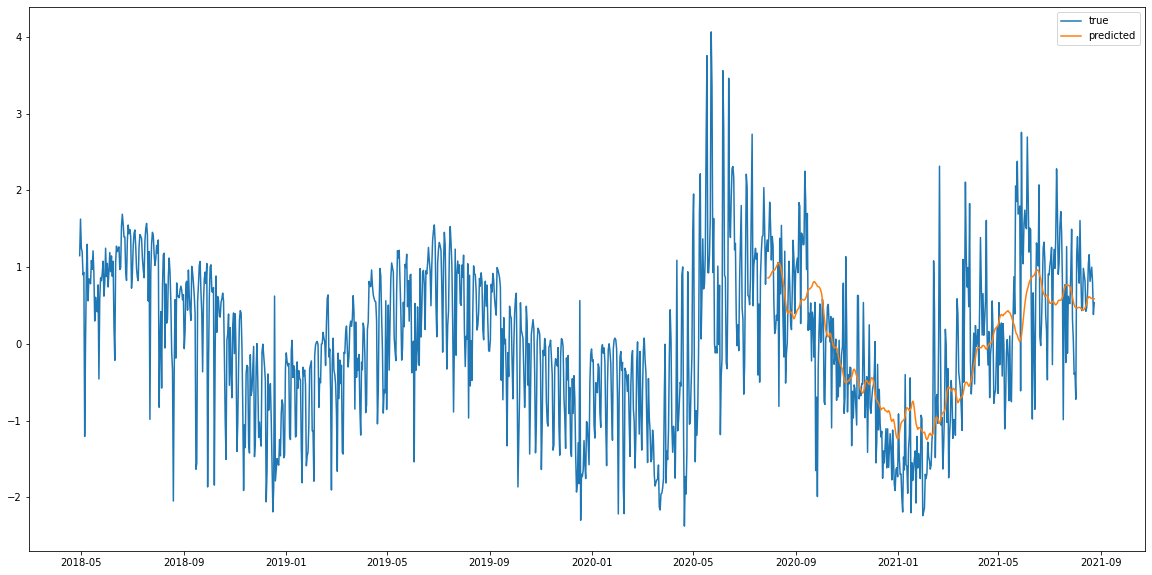

In [11]:
y_pred = model.predict(X_test)

def mape(pred, obs):
  return np.mean(np.abs((obs - pred) / obs)) * 100

print("MAPE:", mape(y_pred, y_test))
plt.figure(figsize=(20, 10))
plt.plot(data.index[PAST:], np.concatenate([y_train, y_test]), label="true")
plt.plot(data[split:].index, y_pred, label="predicted")
plt.legend()
plt.show()